<a href="https://colab.research.google.com/github/zlashcomet/Comp3111LEx/blob/main/project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup:
This notebook is intended to be run on Google Colab.

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# MODIFY YOUR PATH
data_path = "/content/drive/MyDrive/COMP4211/project/shared-files"
flickr8k_zip = os.path.join(data_path, 'flickr8k.zip')
flickr8k_path = "flickr8k"

In [ ]:
# Rather than access it directly from Google Drive, unzip the training image datasets to the Google Colab VM.
!mkdir -p "$flickr8k_path"
!unzip "$flickr8k_zip" -d "$flickr8k_path" > /dev/null 2>&1

In [ ]:
# Set it to True when you want to show the testing outputs.
Analysis_testing = True

# Imports

In [ ]:
import numpy as np
import pickle
import tensorflow as tf
import re

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM

# Visualize running progress
from tqdm.notebook import tqdm

# Not sure if nltk is needed
# import nltk
# nltk.download('punkt')
# from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import sys

# 1. Dataset Preparation

## Feature Extraction

In [ ]:
TARGET_SIZE = (224, 224)

In [ ]:
# Functions for showing images
def test_display_image(img_names: str, size: None | tuple) -> None:
    """Display an image

    Args:
        img_names (list[str]): The the name of images.
        size (None | tuple): The size of image to show
    """
    img_dir_path = os.path.join(flickr8k_path, 'Images')
    img_path = os.path.join(img_dir_path, img_names)
    image: np.ndarray = img_to_array(load_img(img_path, target_size=size))
    image = image.astype(int)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()  # Make the subplots more packed
    plt.show()

def test_compare_cropped_image(img_names: list[str]) -> None:
    """It either compares the original images and resized images that fit to the VGG19

    Args:
        img_names (list[str]): The list contains names of images.
    """
    img_dir_path = os.path.join(flickr8k_path, 'Images')
    n = len(img_names)
    Sizes = [None, TARGET_SIZE]
    # Show all three img in subplot
    fig, axs = plt.subplots(2, n, figsize=(8, 8))
    for idx, size in enumerate(Sizes):
        for j in range(n):
            if idx == 0:
                Title = "Original image"
            else:
                Title = "Resized images"
            img_path = os.path.join(img_dir_path, img_names[j])
            image: np.ndarray = img_to_array(load_img(img_path, target_size=size))
            image = image.astype(int)
            axs[idx, j].imshow(image)
            axs[idx, j].set_title(Title)
            axs[idx, j].axis('off')  # Remove the axes
    fig.suptitle("Comparison of original image with resized one that fit to the VGG19")
    fig.tight_layout()  # Make the subplots more packed
    plt.show()

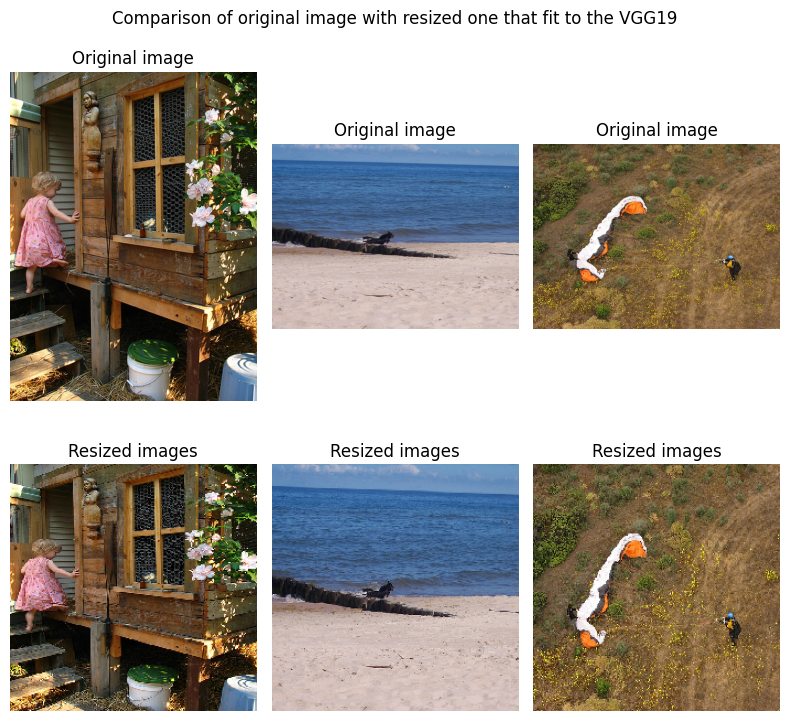

In [ ]:
if Analysis_testing == True:
    # Pick three image to display
    imgs_to_display = ["1000268201_693b08cb0e.jpg", "1115679311_245eff2f4b.jpg", "2057306459_2f52ce648e.jpg"]
    test_compare_cropped_image(imgs_to_display)

In [ ]:
# Load image extraction model
def load_extraction_model():
    # Load VGG19 model
    model = VGG19()
    # Modify the model and drop the final output layer (softmax) of the VGG19 model
    model = Model(inputs=model.input, outputs=model.layers[-2].output)
    return model

# Extract image features
def extract_features(dir_path: str, model):
    features = {}
    img_dir_path = os.path.join(dir_path, 'Images')
    img_names = tqdm(os.listdir(img_dir_path))
    for img_name in img_names:
        # Get the image path
        img_path = img_dir_path + '/' + img_name
        # Load and convert the image to a numpy array
        image = img_to_array(load_img(img_path, target_size=TARGET_SIZE))
        # Reshape the image to fit into the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Preprocess the image
        image = preprocess_input(image)
        # Feature extraction
        feature = model.predict(image, verbose=0)
        # Store the feature
        features[img_name] = feature
    return features

# Extract image features and save it into a pickle (.pkl) file
def extract_save_features(dir_path: str, feature_path: str, model):
    features = extract_features(dir_path, model)
    f = open(feature_path, 'wb') # 'wb': Write binary
    pickle.dump(features, f)
    f.close()

# Load image features from pickle file
def load_features(feature_path: str):
    f = open(feature_path, 'rb') # 'rb': Read binary
    features = pickle.load(f)
    f.close()
    return features

In [ ]:
# Load image extraction model
extraction_model = load_extraction_model()

31

## Word Embedding

In [ ]:
def load_embeddings():
    embeddings = {}
    glove_path = os.path.join(data_path, 'glove.6B.50d.txt')
    f = open(glove_path, encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]
        embeddings[word] = np.array(values[1:],dtype='float')
    f.close()
    return embeddings

def get_embedding_matrix(num_vocab: int, word_to_index: dict, embeddings: dict):
    emb_dim = 50
    embedding_matrix = np.zeros((num_vocab, emb_dim))
    for word, index in word_to_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix

In [ ]:
embeddings = load_embeddings()
embedding_matrix = get_embedding_matrix(num_vocab, word_to_index, embeddings)

In [ ]:
embedding_matrix.shape

(2840, 50)

## Caption Data Batch Generation

In [ ]:
class CaptionDataset:
    def __init__(self, ds: dict, batch_size: int):
        """
        ds (dict): The PREPROCESSED caption dataset
        img_names (list): A list of image filenames
        img_index (int): Stores the current index to img_names used for batch generation
        batch_size (int): The size of the batch
        """
        self.ds = ds
        self.img_filenames = self.load_img_filenames()
        self.img_index = 0 # At initial, the index is 0
        self.batch_size = batch_size

    def reset_index(self):
        self.img_index = 0

    def load_img_filenames(self):
        return [x for x in self.ds.keys()]

    """
    features (dict): A dictionary obtained from the feature extraction section
    word_to_index (dict): A dictionary having (word, index) as a key-value pair
    max_length (int): The maximum length of the caption
    num_vocab (int): Number of vocabulary in the mappings
    """
    def generate_batch_data(self, features: dict, word_to_index: dict, max_length: int, num_vocab: int):
        """
        img_features (list): A list of feature vectors
        partial_captions (list): A list of captions in the format below (indexed):
            [
                ['<START>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>' ... '<PAD>'],
                ['<START>' '<WORD_1>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>' ... '<PAD>'],
                ['<START>' '<WORD_1>' '<WORD_2>' ... '<PAD>' '<PAD>' '<PAD>' ... '<PAD>'],
                ...
                ['<START>' '<WORD_1>' '<WORD_2>' ... '<WORD_N>' '<PAD>' '<PAD>' ... '<PAD>'],
                ['<START>' '<WORD_1>' '<WORD_2>' ... '<WORD_N>' '<END>' '<PAD>' ... '<PAD>']
            ]
        target_words (list): A list of the word proceeding to the caption, presented in one-hot encoded form
        """
        img_features, partial_captions, target_words = [], [], []
        for i in range(self.batch_size):
            # Get the filename of the image
            filename = self.img_filenames[self.img_index]

            # Increment the index
            self.img_index = (self.img_index + 1) % self.__len__()

            # Get the feature vector and the captions of the image
            img_feature = features[filename]
            captions = self.ds[filename]

            for caption in captions:
                sequence = [word for word in caption.split()]

                # Convert the words into their correspoinding word index
                for j in range(len(sequence)):
                    if sequence[j] in word_to_index:
                        sequence[j] = word_to_index[sequence[j]]
                    else: # If the word does not exist in the dictionary, assign the index of '<UNKNOWN>' to it
                        sequence[j] = word_to_index[UNKNOWN]

                for k in range(1, len(sequence)):
                    x_k = sequence[0:k]
                    y_k = sequence[k]

                    # Pad the list with the corresponding index of '<PAD>' at the back of the sequence until the length reaches the maximum length of the caption
                    x_k = pad_sequences([x_k], maxlen=max_length, value=word_to_index[PAD], padding='post')[0]
                    y_k = to_categorical([y_k], num_classes=num_vocab+1)[0]

                    img_features.append(img_feature)
                    partial_captions.append(x_k)
                    target_words.append(y_k)

        return [[np.array(img_features), np.array(partial_captions)], np.array(target_words)]

    def __len__(self):
        return len(self.img_filenames)

In [ ]:
test_caption_dataset = CaptionDataset(ds, 3)
test_batch = test_caption_dataset.generate_batch_data(features, word_to_index, max_length, num_vocab)

In [ ]:
print(test_batch[0][0])

574710816/574710816 [==============================] - 6s 0us/step


In [ ]:
extraction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Store the path of features.pkl
feature_path = os.path.join(data_path, 'features.pkl')

In [ ]:
# Do NOT need to run this if the .pkl file already exists
if not os.path.exists(feature_path):
    print("Start extracting")
    extract_save_features(dir_path=flickr8k_path, feature_path=feature_path, model=extraction_model)
    print("Finish extracting")
else:
    print("The file already exist, please continue with next tasks")

The file already exist, please continue with next tasks


In [ ]:
# Run this if the .pkl file already exists
if not os.path.exists(feature_path):
    raise Exception("Feature path does not exist")
features = load_features(feature_path=feature_path)
print("Features are loaded successfully")

Features are loaded successfully


In [ ]:
len(features)   # Should be 8091

8091

## Load Captions

In [ ]:
def load_dataset(dir_path: str) -> dict:
    """
    key: image_filename
    value: [caption_1, caption_2, caption_3, caption_4, caption_5]
    """
    ds = {}
    caption_path = os.path.join(dir_path, 'captions.txt')

    # Open the caption.txt file and extract the text
    f = open(caption_path, 'r')
    next(f) # Skip the first line (i.e., "image,caption")
    doc = f.read()
    f.close()
    lines = doc.split('\n')[:-1] # Skip the last empty line

    for line in lines:
        """
        Format for each line:
        <image_filname>,<caption>
        """
        tokens = line.split(',')
        if len(tokens) != 2:
            continue
        image_filename, caption = tokens[0], tokens[1]
        # Add the image filename as key if it is not in the dictionary
        if image_filename not in ds:
            ds[image_filename] = []
        # Append the caption to the caption list
        ds[image_filename].append(caption)

    return ds

In [ ]:
ds = load_dataset(flickr8k_path)

In [ ]:
print(len(ds))  # 8091
print(ds['1000268201_693b08cb0e.jpg'])

8091
['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


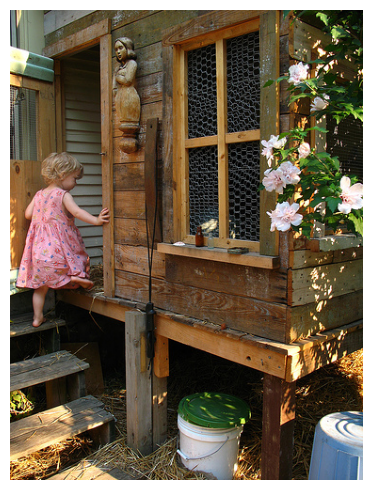

In [ ]:
# Check the an image
if Analysis_testing == True:
    test_display_image('1000268201_693b08cb0e.jpg', size = None)

# 2. Data Preprocessing

## Caption Formatting

In [ ]:
# Special Tokens
START = "<START>"
END = "<END>"
PAD = "<PAD>"
UNKNOWN = "<UNKNOWN>"
special_tokens = [START, END, PAD, UNKNOWN]

In [ ]:
def preprocess_ds(ds: dict):
    for filename, captions in ds.items():
        for i in range(len(captions)):
            # Make the caption lowercase
            # Delete non-alphabets
            # Trim down space
            caption = re.sub('[^A-Za-z\s+]', '', captions[i].lower()).replace('\s+', ' ')
            # Caption format: "<START> {token_1} {token_2} ... {token_n} <END>"
            # Remove hanging 's' and 'a'
            captions[i] = START + ' ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' ' + END
    return ds

In [ ]:
# At this point, the captions stored in ds should follow the format defined above
ds = preprocess_ds(ds)

In [ ]:
def get_vocab_variables(ds: dict):
    word_to_index = {}
    index_to_word = {}
    word_freq = {}
    num_vocab = 0
    max_length = 0

    # For every caption, extract every word and count the frequencies of the tokens
    for filename, captions in ds.items():
        for caption in captions:
            tokens = caption.split(' ')
            max_length = max(max_length, len(tokens))
            for token in tokens:
                if token not in word_freq.keys():
                    word_freq[token] = 0
                word_freq[token] += 1

    # Filter out words that occur less than 5 times and special tokens
    trimmed_word_freq = sorted({word : freq for word, freq in word_freq.items() if freq >= 5 and word not in special_tokens})

    # Number of vocabulary: number of words having frequencies greater than 5 + 4 special tokens (<START>, <END>, <PAD> and <UNKNOWN>)
    i = len(trimmed_word_freq)
    num_vocab = i + 4

    # Note: Index starts from 1 for enumerate list
    for index, word in enumerate(trimmed_word_freq):
        word_to_index[word] = index
        index_to_word[index] = word

    word_to_index[START] = i + 1
    index_to_word[i + 1] = START

    word_to_index[END] = i + 2
    index_to_word[i + 2] = END

    word_to_index[PAD] = i + 3
    index_to_word[i + 3] = PAD

    word_to_index[UNKNOWN] = i + 4
    index_to_word[i + 4] = UNKNOWN

    return word_to_index, index_to_word, num_vocab, max_length

In [ ]:
word_to_index, index_to_word, num_vocab, max_length = get_vocab_variables(ds)

In [ ]:
len(word_to_index)  # 2840

2840

In [ ]:
if Analysis_testing == True:
    print(index_to_word)

{0: 'abandoned', 1: 'about', 2: 'above', 3: 'accordion', 4: 'acrobatic', 5: 'across', 6: 'act', 7: 'action', 8: 'active', 9: 'adult', 10: 'adults', 11: 'advertisement', 12: 'advertising', 13: 'aerial', 14: 'african', 15: 'africanamerican', 16: 'after', 17: 'afternoon', 18: 'against', 19: 'aged', 20: 'agility', 21: 'ahead', 22: 'aid', 23: 'aiming', 24: 'aims', 25: 'air', 26: 'airborne', 27: 'airplane', 28: 'airport', 29: 'alike', 30: 'all', 31: 'alley', 32: 'almost', 33: 'alone', 34: 'along', 35: 'alongside', 36: 'also', 37: 'ambulance', 38: 'american', 39: 'amid', 40: 'amidst', 41: 'among', 42: 'amongst', 43: 'amusement', 44: 'an', 45: 'and', 46: 'animal', 47: 'animals', 48: 'ankle', 49: 'another', 50: 'apart', 51: 'apartment', 52: 'appear', 53: 'appears', 54: 'apple', 55: 'apples', 56: 'approaches', 57: 'approaching', 58: 'apron', 59: 'aqua', 60: 'arcade', 61: 'arch', 62: 'are', 63: 'area', 64: 'arena', 65: 'arm', 66: 'armenian', 67: 'arms', 68: 'army', 69: 'around', 70: 'art', 71: 'a

In [ ]:
num_vocab  # 2840

2840

In [ ]:
max_length  # 31

31

In [ ]:
if Analysis_testing == True:
    print(ds)

{'1000268201_693b08cb0e.jpg': ['<START> child in pink dress is climbing up set of stairs in an entry way <END>', '<START> girl going into wooden building <END>', '<START> little girl climbing into wooden playhouse <END>', '<START> little girl climbing the stairs to her playhouse <END>', '<START> little girl in pink dress going into wooden cabin <END>'], '1001773457_577c3a7d70.jpg': ['<START> black dog and spotted dog are fighting <END>', '<START> black dog and tricolored dog playing with each other on the road <END>', '<START> black dog and white dog with brown spots are staring at each other in the street <END>', '<START> two dogs of different breeds looking at each other on the road <END>', '<START> two dogs on pavement moving toward each other <END>'], '1002674143_1b742ab4b8.jpg': ['<START> little girl covered in paint sits in front of painted rainbow with her hands in bowl <END>', '<START> little girl is sitting in front of large painted rainbow <END>', '<START> small girl in the g

## Word Embedding

In [80]:
def load_embeddings():
    embeddings = {}
    glove_path = os.path.join(data_path, 'glove.6B.50d.txt')
    f = open(glove_path, encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]
        embeddings[word] = np.array(values[1:],dtype='float')
    f.close()
    return embeddings

def get_embedding_matrix(num_vocab: int, word_to_index: dict, embeddings: dict):
    emb_dim = 50
    embedding_matrix = np.zeros((num_vocab, emb_dim))
    for word, index in word_to_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix

In [81]:
embeddings = load_embeddings()
embedding_matrix = get_embedding_matrix(num_vocab, word_to_index, embeddings)

In [82]:
embedding_matrix.shape  # (2840, 50)

(2840, 50)

## Caption Data Batch Generation

In [83]:
class CaptionDataset:
    def __init__(self, ds: dict, batch_size: int):
        """
        ds (dict): The PREPROCESSED caption dataset
        img_names (list): A list of image filenames
        img_index (int): Stores the current index to img_names used for batch generation
        batch_size (int): The size of the batch
        """
        self.ds = ds
        self.img_filenames = self.load_img_filenames()
        self.img_index = 0 # At initial, the index is 0
        self.batch_size = batch_size

    def reset_index(self):
        self.img_index = 0

    def load_img_filenames(self):
        return [x for x in self.ds.keys()]

    """
    features (dict): A dictionary obtained from the feature extraction section
    word_to_index (dict): A dictionary having (word, index) as a key-value pair
    max_length (int): The maximum length of the caption
    num_vocab (int): Number of vocabulary in the mappings
    """
    def generate_batch_data(self, features: dict, word_to_index: dict, max_length: int, num_vocab: int):
        """
        img_features (list): A list of feature vectors
        partial_captions (list): A list of captions in the format below (indexed):
            [
                ['<START>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>' ... '<PAD>'],
                ['<START>' '<WORD_1>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>' ... '<PAD>'],
                ['<START>' '<WORD_1>' '<WORD_2>' ... '<PAD>' '<PAD>' '<PAD>' ... '<PAD>'],
                ...
                ['<START>' '<WORD_1>' '<WORD_2>' ... '<WORD_N>' '<PAD>' '<PAD>' ... '<PAD>'],
                ['<START>' '<WORD_1>' '<WORD_2>' ... '<WORD_N>' '<END>' '<PAD>' ... '<PAD>']
            ]
        target_words (list): A list of the word proceeding to the caption, presented in one-hot encoded form
        """
        img_features, partial_captions, target_words = [], [], []
        for i in range(self.batch_size):
            # Get the filename of the image
            filename = self.img_filenames[self.img_index]

            # Increment the index
            self.img_index = (self.img_index + 1) % self.__len__()

            # Get the feature vector and the captions of the image
            img_feature = features[filename]
            captions = self.ds[filename]

            for caption in captions:
                sequence = [word for word in caption.split()]

                # Convert the words into their correspoinding word index
                for j in range(len(sequence)):
                    if sequence[j] in word_to_index:
                        sequence[j] = word_to_index[sequence[j]]
                    else: # If the word does not exist in the dictionary, assign the index of '<UNKNOWN>' to it
                        sequence[j] = word_to_index[UNKNOWN]

                for k in range(1, len(sequence)):
                    x_k = sequence[0:k]
                    y_k = sequence[k]

                    # Pad the list with the corresponding index of '<PAD>' at the back of the sequence until the length reaches the maximum length of the caption
                    x_k = pad_sequences([x_k], maxlen=max_length, value=word_to_index[PAD], padding='post')[0]
                    y_k = to_categorical([y_k], num_classes=num_vocab+1)[0]

                    img_features.append(img_feature)
                    partial_captions.append(x_k)
                    target_words.append(y_k)

        return [[np.array(img_features), np.array(partial_captions)], np.array(target_words)]

    def __len__(self):
        return len(self.img_filenames)

test_caption_dataset = CaptionDataset(ds, 3)
test_batch = test_caption_dataset.generate_batch_data(features, word_to_index, max_length, num_vocab)

In [84]:
if Analysis_testing == True:
    print(test_batch[0][0])

[[[0.        1.8023192 0.        ... 0.        0.        0.       ]]

 [[0.        1.8023192 0.        ... 0.        0.        0.       ]]

 [[0.        1.8023192 0.        ... 0.        0.        0.       ]]

 ...

 [[0.        0.        0.        ... 0.        1.3614898 0.       ]]

 [[0.        0.        0.        ... 0.        1.3614898 0.       ]]

 [[0.        0.        0.        ... 0.        1.3614898 0.       ]]]


In [85]:
if Analysis_testing == True:
    print(test_batch[0][1])

[[2837 2839 2839 ... 2839 2839 2839]
 [2837  465 2839 ... 2839 2839 2839]
 [2837  465 1206 ... 2839 2839 2839]
 ...
 [2837 2831  996 ... 2839 2839 2839]
 [2837 2831  996 ... 2839 2839 2839]
 [2837 2831  996 ... 2839 2839 2839]]


In [86]:
if Analysis_testing == True:
    print(test_batch[1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


# Model Training

Useful global variables:
1. `features`: A dictionary, with file name of images as keys (e.g. `1000268201_693b08cb0e.jpg`), and its corresponding feature vectors as values, Extracted from `VGG19`, with length of `4096`.
2. `ds`: A dictionary, with file name of images as keys (e.g. `1000268201_693b08cb0e.jpg`), corresponding captions as values , `['\<START> child in pink ... \<END>',
  '\<START> girl ... \<END>', ...
  '\<START> little ... cabin \<END>']`.
3. `embedding_matrix`: A numpy ndarray with each row as the word in the vocabulary, but the value of the word become its vector representation `(pre-trained,  50 in length)`.
4. `img_features`: VGG19 extracted feature vectors corresponding to each of the images in the batch. It is repetitive for every sub-partial captions for the the particular image.
5. `partial_captions`: A 2D list, each row is a `PREPROCESSED` sentence, consist of special tokens which is converted to index in the vocabulary.It is noted that each caption of the image has 5 sentences, and each type of sentences in partial_captions are started with a extra sentence that is fullly filled with \<PAD>. i.e. `['\<START>, \<PAD>, ..., \<PAD>, \<END>']`
6. `target_words`: Corresponding  target words for partial captions
7. `word_to_index`: A dictionary, which is the vocabulary with `word` as key, `index` as value.
8. `index_to_word`: A dictionary, which is the vocabulary with `index` as key, `word` as value.
9. `num_vocab`: Total numbers words in the vocabulary, which is `2840`
10. `max_length`: The maximum length of each sentence in the caption.

## Encoder Building

## Decoder Building